In [1]:
import pandas as pd
import numpy as np
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree
import sklearn.ensemble
from sklearn.neural_network import MLPClassifier
import matplotlib.colors as mcolors

In [2]:
# Load in merged SWOT and ice mask data for polygon 01 for 07/19/2025
poly_01 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_SWOT_icemask.csv")
poly_01

# Define features and target
features = ['phase_noise_std', 'waterfrac', 'sig0']
target = ['ice_mask']

# Create X and y
X = poly_01[features]
X = np.array(X)
y = poly_01[target]

# Split data into 80% training and 20% testing
np.random.seed(42)
nsamples = int(len(y) * 0.8)
idx = np.random.choice(y.size,nsamples)
m = np.zeros(y.size).astype(np.int)
m[idx] = 1
m = m.astype(np.bool)
#Divide into training and validation
Xt = X[m,:]
yt = y[m]
Xv = X[~m,:]
yv = y[~m]

In [5]:
# Load in snow mask data
filepath = "../../../../shared_space/SWOT_Aufeis/snow_mask/poly_01_20250719_snow.tif"
snowmask_src = rasterio.open(filepath)
# Read band 1
snowmask_20250603 = snowmask_src.read(1)

In [17]:
# Decision Tree Classifier
clf = sklearn.tree.DecisionTreeClassifier(random_state=1)
#Fit the tree
clf = clf.fit(Xt,yt)
#Assess the accuracy using the training dataset
print('Training Accuracy:',clf.score(Xt, yt))
#Assess the accuracy using the validation dataset
print('Validation Accuracy:',clf.score(Xv,yv))
# Predict on full X to create map later
y_pred_full_clf = clf.predict(X)

Training Accuracy: 1.0
Validation Accuracy: 0.9101512965149329


In [3]:
# Random Forest Classifier
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True)
#Fit the tree
rf = rf.fit(X,y)
#Perform 10-fold cross validation to estimate performance
rf_scores = sklearn.model_selection.cross_val_score(rf,X,y,cv=10)
print('Random Forest Accuracy:',np.mean(rf_scores))
# Predict on full X to create map later
y_pred_full = rf.predict(X)
print('Random forest out of bag score:',rf.oob_score_)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Random Forest Accuracy: 0.9061703541483743
Random forest out of bag score: 0.9124285476169466


In [6]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(200,100),max_iter=500)
#Fit the MLP
mlp = mlp.fit(X, y)
#Perform 10-fold cross validation to estimate performance
mlp_scores = sklearn.model_selection.cross_val_score(mlp,X,y,cv=10)
print('Multilayer Perceptron Accuracy:', np.mean(mlp_scores))
# Predict on full X to create map later
y_pred_full_mlp = mlp.predict(X)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d arr

Multilayer Perceptron Accuracy: 0.9228039574551049


In [6]:
# Get ready to plot classification results

# mask NANs
raster_to_plot = np.ma.masked_invalid(snowmask_20250603)
# define colormap
cmap_raster = mcolors.ListedColormap(['darkgray', 'lightblue'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap_raster.N)

# compute spatial extent from rasterio transform
height, width = snowmask_20250603.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(height, width, snowmask_src.transform)
extent = (minx, maxx, miny, maxy)

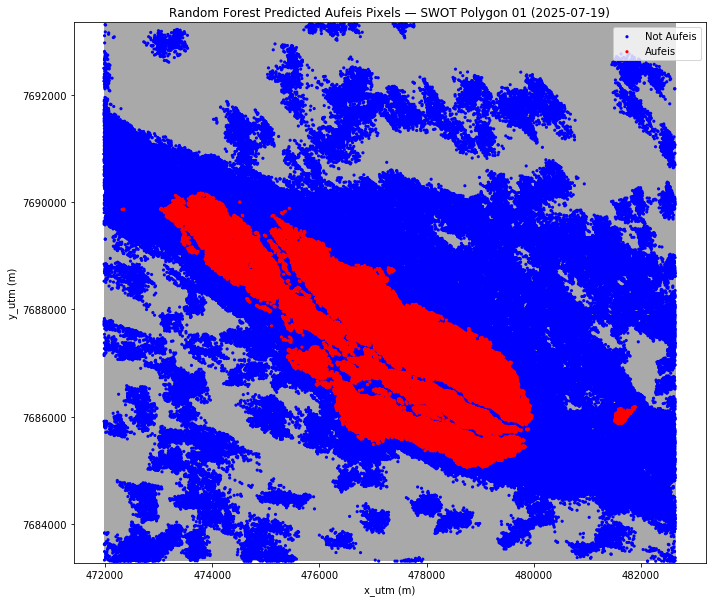

In [7]:
# Plot Random Forest results
auf = poly_01[y_pred_full == 1]
not_auf = poly_01[y_pred_full == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot background raster
im = ax.imshow(raster_to_plot, cmap=cmap_raster, norm=norm, extent=extent,
               origin='upper', interpolation='nearest')

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf['x_utm'], not_auf['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf['x_utm'], auf['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)')
ax.legend()

plt.tight_layout()
plt.show()

auf_rf = auf

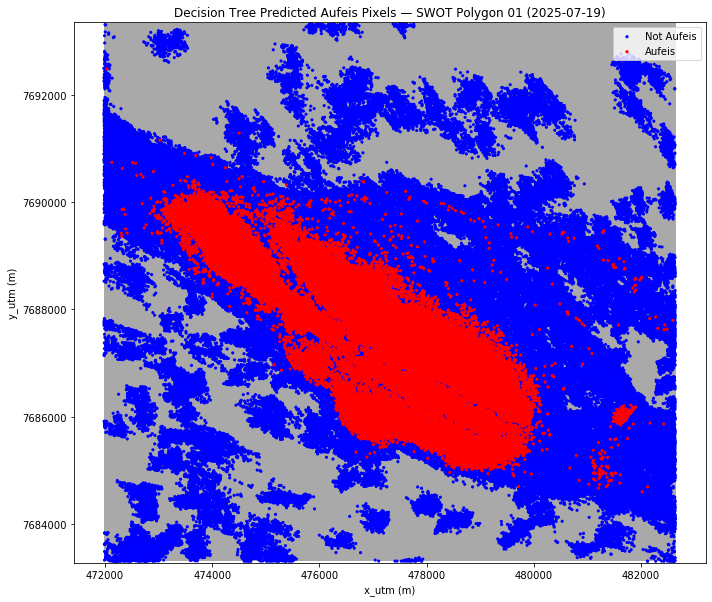

In [18]:
# Plot Decision Tree results
auf = poly_01[y_pred_full_clf == 1]
not_auf = poly_01[y_pred_full_clf == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot background raster
im = ax.imshow(raster_to_plot, cmap=cmap_raster, norm=norm, extent=extent,
               origin='upper', interpolation='nearest')

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf['x_utm'], not_auf['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf['x_utm'], auf['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Decision Tree Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)')
ax.legend()

plt.tight_layout()
plt.show()

auf_tree = auf

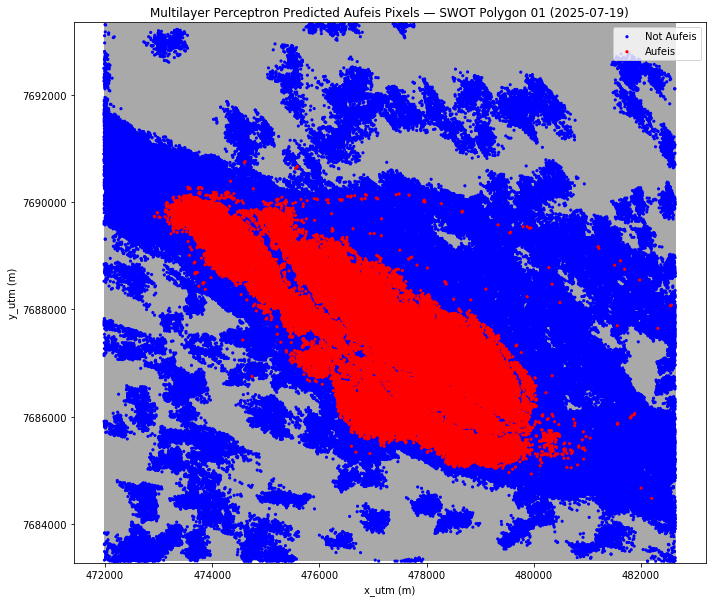

In [19]:
# Plot MLP results
auf = poly_01[y_pred_full_mlp == 1]
not_auf = poly_01[y_pred_full_mlp == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot background raster
im = ax.imshow(snowmask_20250603, cmap=cmap_raster, norm=norm, extent=extent,
               origin='upper', interpolation='nearest')

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf['x_utm'], not_auf['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf['x_utm'], auf['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Multilayer Perceptron Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑19)')
ax.legend()

plt.tight_layout()
plt.show()

auf_mlp = auf

In [21]:
# Save each aufeis extent df as a csv
auf_rf_output = "../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_aufeis_random_forest.csv"
auf_rf.to_csv(auf_rf_output, index=False)

auf_tree_output = "../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_aufeis_decision_tree.csv"
auf_tree.to_csv(auf_tree_output, index=False)

auf_mlp_output = "../../../../shared_space/SWOT_Aufeis/joined_SWOT_ice_mask/poly_01_20250719_aufeis_mlp.csv"
auf_mlp.to_csv(auf_mlp_output, index=False)

In [ ]:
# Load in polygon 1 testing data
poly_01_710 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC_poly1_20250710.csv")
poly_01_720 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC_poly1_20250720.csv")
poly_01_729 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC_poly1_20250729.csv")
poly_01_822 = pd.read_csv("../../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/filtered_SWOT_PIXC_poly1_20250822.csv")

In [ ]:
# Create X and y sets for each date of polygon 1
X_710 = poly_01_710[features]
X_710 = np.array(X_710)
y_710 = poly_01_710[target]

X_720 = poly_01_720[features]
X_720 = np.array(X_720)
y_720 = poly_01_720[target]

X_729 = poly_01_729[features]
X_729 = np.array(X_729)
y_729 = poly_01_729[target]

X_822 = poly_01_822[features]
X_822 = np.array(X_822)
y_822 = poly_01_822[target]

In [ ]:
# Run Random Forest on each of the polygon 1 testing datasets
y_pred_full_710 = rf.predict(X_710)
print('Random forest out of bag score 7/10:',rf.oob_score_)

y_pred_full_720 = rf.predict(X_720)
print('Random forest out of bag score 7/20:',rf.oob_score_)

y_pred_full_729 = rf.predict(X_729)
print('Random forest out of bag score 7/29:',rf.oob_score_)

y_pred_full_822 = rf.predict(X_822)
print('Random forest out of bag score 8/22:',rf.oob_score_)

In [ ]:
# Make plot of each predicted date
auf_710 = poly_01_710[y_pred_full_710 == 1]
not_auf_710 = poly_01_710[y_pred_full_710 == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf_710['x_utm'], not_auf_710['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf_710['x_utm'], auf_710['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑10)')
ax.legend()

plt.tight_layout()
plt.show()

auf_rf_710 = auf_710


auf_720 = poly_01_720[y_pred_full_720 == 1]
not_auf_720 = poly_01_720[y_pred_full_720 == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf_720['x_utm'], not_auf_720['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf_720['x_utm'], auf_720['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑20)')
ax.legend()

plt.tight_layout()
plt.show()

auf_rf_720 = auf_720


auf_729 = poly_01_729[y_pred_full_729 == 1]
not_auf_729 = poly_01_729[y_pred_full_729 == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf_729['x_utm'], not_auf_729['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf_729['x_utm'], auf_729['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑07‑29)')
ax.legend()

plt.tight_layout()
plt.show()

auf_rf_729 = auf_729

auf_822 = poly_01_822[y_pred_full_822 == 1]
not_auf_822 = poly_01_822[y_pred_full_822 == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot blue points (not aufeis) first, zorder=2
ax.scatter(not_auf_822['x_utm'], not_auf_822['y_utm'],
           color='blue', s=10, edgecolor='none', label='Not Aufeis', zorder=2)

# Plot red points (aufeis) **after**, so they overlay the blue ones
ax.scatter(auf_822['x_utm'], auf_822['y_utm'],
           color='red', s=10, edgecolor='none', label='Aufeis', zorder=3)

# Labels and titles
ax.set_xlabel('x_utm (m)')
ax.set_ylabel('y_utm (m)')
ax.set_aspect('equal', adjustable='box')
ax.set_title('Random Forest Predicted Aufeis Pixels — SWOT Polygon 01 (2025‑08‑22)')
ax.legend()

plt.tight_layout()
plt.show()

auf_rf_822 = auf_822

In [ ]:
# Save aufeis extent for each day as a csv
auf_710 = poly_01_710[y_pred_full_710 == 1]
auf_710_rf_output = "/Users/clk69/Downloads/poly_01_20250710_aufeis_random_forest.csv"
auf_rf_710.to_csv(auf_710_rf_output, index=False)

auf_720 = poly_01_720[y_pred_full_720 == 1]
auf_720_rf_output = "/Users/clk69/Downloads/poly_01_20250720_aufeis_random_forest.csv"
auf_rf_720.to_csv(auf_720_rf_output, index=False)

auf_729 = poly_01_729[y_pred_full_729 == 1]
auf_729_rf_output = "/Users/clk69/Downloads/poly_01_20250729_aufeis_random_forest.csv"
auf_rf_729.to_csv(auf_729_rf_output, index=False)

auf_822 = poly_01_822[y_pred_full_822 == 1]
auf_822_rf_output = "/Users/clk69/Downloads/poly_01_20250822_aufeis_random_forest.csv"
auf_rf_822.to_csv(auf_822_rf_output, index=False)